In [13]:
!pip install spacy
!pip install gcsfs

  Using cached https://files.pythonhosted.org/packages/9e/9b/62c60d2f5bc135d2aa1d8c8a86aaf84edb719a59c7f11a4316259e61a298/plac-0.9.6-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b6/43/39372a0bc24d336dc88b87262c30f09d0a2c759f32a2965f90fb56da46f1/cymem-1.31.2-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7d/e6/19dfaff08fcbee7f3453e5b537e65a8364f1945f921a36d08be1e2ff3475/tqdm-4.24.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/84/09/fc890664a7a1dd0a88f46c93fb9340d0a27a69e82095a4a54aef2ed94a6d/msgpack_numpy-0.4.3.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/08/72/5a01d2a6a894e7f6966b0038445c748d7a16754cceb0e988699269d8152a/msgpack-0.5.6-cp35-cp35m-manylinux1_x86_64.whl
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however versi

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import spacy
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import dask.dataframe as dd
from nltk.corpus import stopwords, inaugural
import nltk



Inspect files and pick two to analyze

In [16]:
inaugural.fileids()

['1789-Washington.txt',
 '1793-Washington.txt',
 '1797-Adams.txt',
 '1801-Jefferson.txt',
 '1805-Jefferson.txt',
 '1809-Madison.txt',
 '1813-Madison.txt',
 '1817-Monroe.txt',
 '1821-Monroe.txt',
 '1825-Adams.txt',
 '1829-Jackson.txt',
 '1833-Jackson.txt',
 '1837-VanBuren.txt',
 '1841-Harrison.txt',
 '1845-Polk.txt',
 '1849-Taylor.txt',
 '1853-Pierce.txt',
 '1857-Buchanan.txt',
 '1861-Lincoln.txt',
 '1865-Lincoln.txt',
 '1869-Grant.txt',
 '1873-Grant.txt',
 '1877-Hayes.txt',
 '1881-Garfield.txt',
 '1885-Cleveland.txt',
 '1889-Harrison.txt',
 '1893-Cleveland.txt',
 '1897-McKinley.txt',
 '1901-McKinley.txt',
 '1905-Roosevelt.txt',
 '1909-Taft.txt',
 '1913-Wilson.txt',
 '1917-Wilson.txt',
 '1921-Harding.txt',
 '1925-Coolidge.txt',
 '1929-Hoover.txt',
 '1933-Roosevelt.txt',
 '1937-Roosevelt.txt',
 '1941-Roosevelt.txt',
 '1945-Roosevelt.txt',
 '1949-Truman.txt',
 '1953-Eisenhower.txt',
 '1957-Eisenhower.txt',
 '1961-Kennedy.txt',
 '1965-Johnson.txt',
 '1969-Nixon.txt',
 '1973-Nixon.txt',
 '1

I'll work with Bush and Obama's inaugural addresses.

In [17]:
obama = inaugural.raw('2009-Obama.txt')
bush = inaugural.raw('2005-Bush.txt')

obama[0:100]

'My fellow citizens:\n\nI stand here today humbled by the task before us, grateful for the trust you ha'

Set up our cleaner function to remove things spacy can't handle and apply it to the obama and bush texts. 

In [18]:
#text cleaner func
def text_cleaner(text):
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\][-]]", "", text)
    text = ' '.join(text.split())
    return text

In [19]:
#Clean data
obama_clean = text_cleaner(obama)
bush_clean = text_cleaner(bush)


In [20]:
!python -m spacy download en 

    100% |████████████████████████████████| 37.4MB 16.1MB/s ta 0:00:011    94% |██████████████████████████████▎ | 35.3MB 82.2MB/s eta 0:00:01
  Running setup.py install for en-core-web-sm ... - \ done
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

    Linking successful
    /usr/local/envs/py3env/lib/python3.5/site-packages/en_core_web_sm -->
    /usr/local/envs/py3env/lib/python3.5/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [21]:
#Parse cleaned data
nlp = spacy.load('en')
obama_doc = nlp(obama_clean)
bush_doc = nlp(bush_clean)

In [22]:
# Group into sentences
bush_sents = [[sent, 'bush'] for sent in bush_doc.sents]
obama_sents = [[sent, 'obma'] for sent in obama_doc.sents]

# Combine
sentences = pd.DataFrame(bush_sents + obama_sents)
sentences.head()

,0,1
0,"(Vice, President, Cheney, ,, Mr., Chief, Justi...",bush
1,"(On, this, day, ,, prescribed, by, law, and, m...",bush
2,"(I, am, grateful, for, the, honor, of, this, h...",bush
3,"(At, this, second, gathering, ,, our, duties, ...",bush
4,"(For, a, half, a, century, ,, America, defende...",bush


We have our data cleaned, parsed, and split into sentences, now we'll create features using bag of words...

In [23]:
# Create bag of words function for each text
def bag_of_words(text):
    
    # filter out punctuation and stop words
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return most common words
    return [item[0] for item in Counter(allwords).most_common(500)]

# Get bags 
bush_words = bag_of_words(bush_doc)
obama_words = bag_of_words(obama_doc)

# Combine bags to create common set of unique words
common_words = set(bush_words + obama_words)



In [24]:
# Create bag of words data frame using combined common words and sentences
def bow_features(sentences, common_words):
    
    # Build data frame
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentences in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentences
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
    
    return df
  
  
# Create bow features 
bow = bow_features(sentences, common_words)
bow.head()

,datum,oppress,mutual,¦,style,cling,soil,leisure,surround,safety,...,planet,worth,effort,slavery,ruler,security,institution,home,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Vice, President, Cheney, ,, Mr., Chief, Justi...",bush
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(On, this, day, ,, prescribed, by, law, and, m...",bush
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(I, am, grateful, for, the, honor, of, this, h...",bush
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(At, this, second, gathering, ,, our, duties, ...",bush
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(For, a, half, a, century, ,, America, defende...",bush


And create features using tf-idf

In [54]:
#create sentences
obama = inaugural.sents('2009-Obama.txt')
bush = inaugural.sents('2005-Bush.txt')

# Create list of text 
obama_list = [" ".join(sent) for sent in obama]
bush_list = [" ".join(sent) for sent in bush]
joined = obama_list + bush_list
outcome = ['obama']*len(obama_list) + ['bush']*len(bush_list)

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(joined, outcome, test_size=0.4, random_state=42)

vectorizer = TfidfVectorizer(encoding='ASCII',
                             max_df=0.7, # drop words that occur in more than 70% the sentences
                             min_df=4, # only use words that appear at least four times
                             stop_words='english', 
                             lowercase=False, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Applying the vectorizer
tfidf=vectorizer.fit_transform(joined)
print("Number of features: %d" % tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tf_idf= train_test_split(tfidf, outcome, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 94
Original sentence: And we will transform our schools and colleges and universities to meet the demands of a new age .
Tf_idf vector: {'hope': 0.558188870005978, 'day': 0.5311348441020588, 'chosen': 0.6374331045546121}


In [56]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 94 to 82.
svd= TruncatedSVD(82)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 99.65457952151468
Component 0:
Our goal instead is to help others find their own voice , attain their own freedom , and make their own way .                                                                                                                                                                                                           0.589290
This is not primarily the task of arms , though we will defend ourselves and our friends by force of arms when necessary .                                                                                                                                                                                              0.589290
Nor is the question before us whether the market is a force for good or ill . Its power to generate wealth and expand freedom is unmatched , but this crisis has reminded us that without a watchful eye , the market can spin out of control -- the nation cannot prosper long when it fa

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


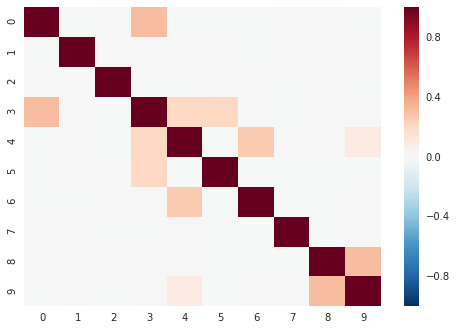

Key:
0 We will persistently clarify the choice before every ruler and every nation : The moral choice between oppression , which is always wrong , and freedom , which is eternally right .
1 Thank you .
2 We go forward with complete confidence in the eventual triumph of freedom .
3 I thank President Bush for his service to our nation , as well as the generosity and cooperation he has shown throughout this transition .
4 To the people of poor nations , we pledge to work alongside you to make your farms flourish and let clean waters flow ; to nourish starved bodies and feed hungry minds .
5 And we will transform our schools and colleges and universities to meet the demands of a new age .
6 It is the honorable achievement of our fathers .
7 And God bless the United States of America .
8 These things are true .
9 It is the kindness to take in a stranger when the levees break , the selflessness of workers who would rather cut their hours than see a friend lose their job which sees us through

In [28]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

## Testing different models

In [57]:
# BoW 
X_bow = bow.drop(['text_sentence', 'text_source'], 1)
Y_bow = bow['text_source']

# Tfidf
X_tfidf = X_train_lsa
Y_tfidf = y_train_tfidf

### Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# BoW
rfc = RandomForestClassifier()
rfc_bow = rfc.fit(X_bow, Y_bow)
print('BoW Random Forest Scores: ', cross_val_score(rfc_bow, X_bow, Y_bow, cv=10))
print('Avg Score:', np.mean(cross_val_score(rfc_bow, X_bow, Y_bow, cv=10)))

# Tfidf
rfc = RandomForestClassifier()
rfc_tfidf = rfc.fit(X_tfidf, Y_tfidf)
print('\nTfidf Random Forest Scores:', cross_val_score(rfc_tfidf, X_tfidf, Y_tfidf, cv=10))
print('Avg Score:', np.mean(cross_val_score(rfc_tfidf, X_tfidf, Y_tfidf, cv=10)))

BoW Random Forest Scores:  [0.66666667 0.58333333 0.70833333 0.69565217 0.65217391 0.63636364
 0.95454545 0.63636364 0.59090909 0.72727273]
Avg Score: 0.7022068511198947

Tfidf Random Forest Scores: [0.53846154 0.61538462 0.46153846 0.76923077 0.61538462 0.41666667
 0.25       0.66666667 0.58333333 0.81818182]
Avg Score: 0.6101398601398602


### Logistic Regression

In [59]:
from sklearn.linear_model import LogisticRegression

# BoW
lr = LogisticRegression()
lr_bow = lr.fit(X_bow, Y_bow)
print('BoW Logistic Regression Scores: ', cross_val_score(lr_bow, X_bow, Y_bow, cv=10))
print('Avg Score:', np.mean(cross_val_score(lr_bow, X_bow, Y_bow, cv=10)))

# Tfidf
lr = LogisticRegression()
lr_tfidf = lr.fit(X_tfidf, Y_tfidf)
print('\nTfidf Logistic Regression Scores:', cross_val_score(lr_tfidf, X_tfidf, Y_tfidf, cv=10))
print('Avg Score:', np.mean(cross_val_score(lr_tfidf, X_tfidf, Y_tfidf, cv=10)))

BoW Logistic Regression Scores:  [0.66666667 0.625      0.70833333 0.86956522 0.73913043 0.72727273
 0.86363636 0.72727273 0.59090909 0.81818182]
Avg Score: 0.733596837944664

Tfidf Logistic Regression Scores: [0.69230769 0.69230769 0.61538462 0.76923077 0.69230769 0.75
 0.58333333 0.75       0.75       0.90909091]
Avg Score: 0.7203962703962704


### Gradient Boosting Classifier

In [60]:
from sklearn.ensemble import GradientBoostingClassifier

# BoW
clf = GradientBoostingClassifier()
clf_bow = clf.fit(X_bow, Y_bow)
print('Bow Gradient Boosting Scores:', cross_val_score(clf_bow, X_bow,Y_bow, cv=10))
print('Avg Score:', np.mean(cross_val_score(clf_bow, X_bow, Y_bow, cv=10)))

# Tfidf
clf = GradientBoostingClassifier()
clf_tfidf = clf.fit(X_tfidf, Y_tfidf)
print('\nTfidf Gradient Boosting Scores:', cross_val_score(clf_tfidf, X_tfidf, Y_tfidf, cv=10))
print('Avg Score:', np.mean(cross_val_score(clf_tfidf, X_tfidf, Y_tfidf, cv=10)))

Bow Gradient Boosting Scores: [0.70833333 0.70833333 0.70833333 0.7826087  0.69565217 0.59090909
 0.77272727 0.63636364 0.59090909 0.72727273]
Avg Score: 0.7044631093544138

Tfidf Gradient Boosting Scores: [0.61538462 0.46153846 0.46153846 0.69230769 0.61538462 0.41666667
 0.5        0.58333333 0.5        0.90909091]
Avg Score: 0.5761655011655011


Logistic Regression has the highest score, but its less consitent across folds. I'll use Gradient Boosting as my model and try to improve it by adding Length of Sentence and Parts of speech.

In [61]:
def parts_of_speech(df):
    counts = [] # initialize list
    for sentence in df.text_sentence: # loop through rows in df.text_sentence column, intialize vars to zero. 
        verbs = 0
        adverbs = 0
        nouns = 0
        puncuation = 0
        length_sentence = len(sentence)
        for token in sentence: #loop through words/tokens in sentence and add one if matched
            if token.pos_ == 'ADV':
                verbs +=1
            elif token.pos_ == 'VERB':
                adverbs +=1
            elif token.pos_ == 'NOUN':
                nouns +=1
            elif token.pos_ == 'PUNCT':
                puncuation +=1
        counts.append([length_sentence, verbs, adverbs, nouns, puncuation]) # append counts to each variable
    df_pos = pd.DataFrame.from_records(counts, columns=['verbs', 'adverbs', 'nouns','puncuation', 'length_sentence']) # turn lists into columns
    df_concat = pd.concat([df, df_pos], axis =1)
    
    return df_concat
bow_pos = parts_of_speech(bow)

bow_pos.head()

,datum,oppress,mutual,¦,style,cling,soil,leisure,surround,safety,...,security,institution,home,text_sentence,text_source,verbs,adverbs,nouns,puncuation,length_sentence
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,"(Vice, President, Cheney, ,, Mr., Chief, Justi...",bush,33,0,0,5,9
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,"(On, this, day, ,, prescribed, by, law, and, m...",bush,31,0,5,6,4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,"(I, am, grateful, for, the, honor, of, this, h...",bush,35,0,8,5,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,"(At, this, second, gathering, ,, our, duties, ...",bush,25,2,5,4,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,"(For, a, half, a, century, ,, America, defende...",bush,18,0,2,4,2


In [66]:
X_bow_pos = bow_pos.drop(['text_sentence', 'text_source'], 1)

# BoW
clf = GradientBoostingClassifier()
clf_bow = clf.fit(X_bow_pos, Y_bow)
print('Bow Gradient Boosting Scores:', cross_val_score(clf_bow, X_bow_pos,Y_bow, cv=10))
print('Avg Score:', np.mean(cross_val_score(clf_bow, X_bow_pos, Y_bow, cv=10)))


Bow Gradient Boosting Scores: [0.70833333 0.66666667 0.70833333 0.7826087  0.7826087  0.68181818
 0.90909091 0.72727273 0.72727273 0.77272727]
Avg Score: 0.7515974967061924


The goal here was to improve the model by 5%, and we went from 70% to 75% by adding Parts of Speech and length of sentences. 